# PROJECT-4. Задача классификации

## Постановка задачи

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

Нам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Мы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если мы сможем это сделать, то поднимем доходы банка и поможем понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

<b>Бизнес-задача:</b> определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

<b>Техническая задача для специалиста в Data Science:</b> построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Какие данные нам предоставили, чтобы мы могли выявить решающие факторы для успеха маркетинговой кампании? В целом их можно разделить на несколько групп.

<b>Данные о клиентах банка:</b>
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

<b>Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:</b>
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

<b>Прочие признаки:</b>
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna

In [2]:
# создаем датафрейм
df = pd.read_csv('bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


1.1. В первую очередь выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [3]:
# проверяем датасет на наличие пропусков
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

1.2. Мы выяснили количество пропущенных значений. Однако, в настоящих данных обычно всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнаем, каким именно словом закодированы пропущенные (неизвестные) значения.

In [4]:
# проверяем наличие неявных пропусков в признаке job
df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

1.3. Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратим внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число.

In [5]:
# преобразуем признак balance в тип float
df['balance'] = df['balance'].replace({'\$': '', ' ': '', ',': '.'}, regex=True).astype(float)
# выводим среднее значение
round(df['balance'].mean(), 3)

1529.129

1.4. Теперь мы можем обработать пропуски в признаке balance.

In [6]:
# заменяем пропуски на медианное значение
df = df.fillna(df.median())
# выводим среднее значение
round(df['balance'].mean(), 3)

1526.936

1.5. Ранее мы выяснили, что в признаке job есть неявные пропуски. Аналогичные пропуски встречаются и в признаке education.

In [7]:
# заменяем все пропущенные значения в признаках job и education на модальные значения
job_mode = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
education_mode = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)
# рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
round(df[(df['job'] == job_mode) & (df['education'] == education_mode)]['balance'].mean(), 3)

1598.883

1.6. Изучим признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха (Q1 - 1.5 x IQR), а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха (Q3 + 1.5 x IQR).

In [8]:
# находим верхнюю и нижнюю границы поиска выбросов по методу Тьюки
iqr = np.percentile(df['balance'], 75) - np.percentile(df['balance'], 25)
upper_limit = np.percentile(df['balance'], 75) + 1.5 * iqr
lower_limit = np.percentile(df['balance'], 25) - 1.5 * iqr
print('Верхняя граница:', upper_limit)
print('Нижняя граница:', lower_limit)

Верхняя граница: 4063.0
Нижняя граница: -2241.0


In [9]:
# удаляем все выбросы
df = df[(df['balance'] <= upper_limit) & (df['balance'] >= lower_limit)]

In [10]:
# проверяем количество объектов после удаления всех выбросов
print('Кол-во объектов:', df.shape[0])

Кол-во объектов: 10105


## Часть 2:  Разведывательный анализ (EDA)

2.1. Изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл.

no     5424
yes    4681
Name: deposit, dtype: int64


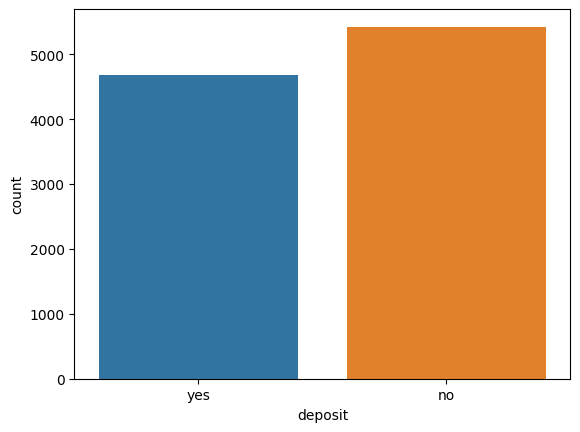

In [11]:
# изучим соотношение классов в наших данных на предмет несбалансированности
print(df.deposit.value_counts())
# проиллюстрируем результат
sns.countplot(x='deposit', data=df);

2.2. Начнём с описательных статистик для количественных переменных.

Рассчитайте их и продумайте подробную интерпретацию.
Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
Рассмотрите минимальные и максимальные значения.
Посмотрите на меры разброса и оцените, насколько данные вариативны.
Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

In [12]:
# выводим описательные статистики для количественных переменных
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


2.3. Теперь рассмотрим описательные статистики для категориальных переменных.

In [13]:
# рассчитаем описательные статистики для категориальных переменных
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


2.4. Давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная.

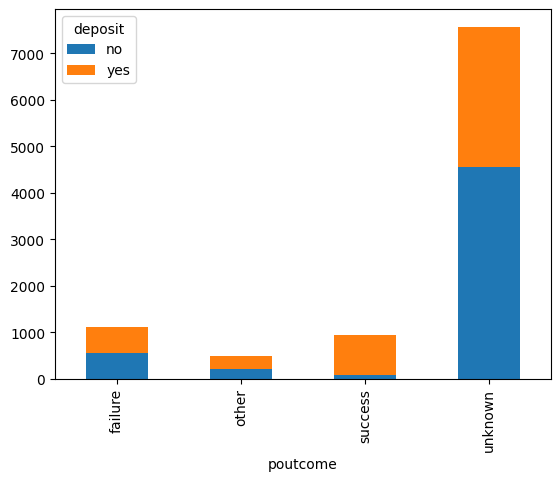

In [14]:
# узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
data = df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
data.plot(kind='bar', stacked='True');

2.5. Узнаем, какова зависимость результата маркетинговых кампаний от месяца. Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

In [15]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
no_deposit_dict = {}
for i in np.unique(df['month']):
    no_deposit_dict[i] = round(df[(df['month'] == i)&(df['deposit'] == 'no')].shape[0]/df[(df['month'] == i)].shape[0], 2)
no_deposit_df = pd.DataFrame.from_dict(no_deposit_dict, orient='index').reset_index()
no_deposit_df.columns = ['month', 'share']
no_deposit_df.sort_values(by='share', ascending=False, ignore_index=True)

,month,share
0,may,0.68
1,jan,0.61
2,jul,0.59
3,nov,0.58
4,aug,0.56
5,jun,0.55
6,feb,0.46
7,apr,0.38
8,oct,0.19
9,sep,0.17


2.6. Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

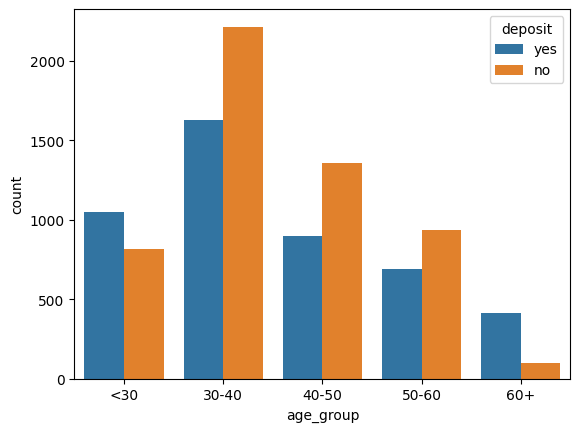

In [16]:
# создаем новый признак возрастной группы
df['age_group'] = pd.cut(df['age'], [0,30,40,50,60,9999], labels = ['<30', '30-40', '40-50', '50-60', '60+'])
# визуализируем результат
sns.countplot(x='age_group', hue='deposit', data=df);

2.7. Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
* семейное положение;
* уровень образования;
* сфера занятости.

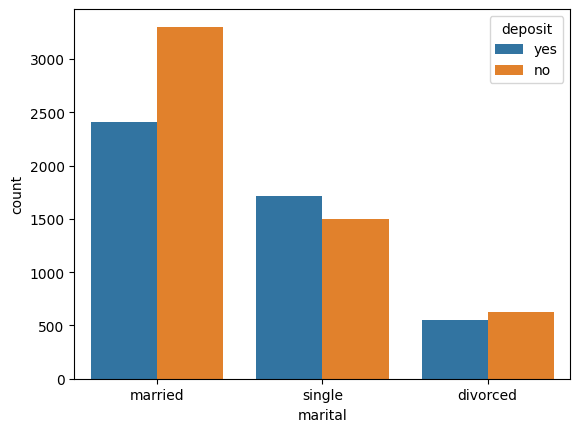

In [17]:
# визуализируем зависимость от семейного статуса
sns.countplot(x='marital', hue='deposit', data=df);

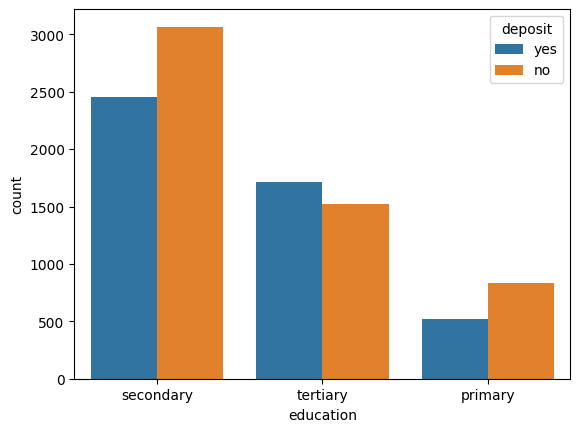

In [18]:
# визуализируем зависимость от образования
sns.countplot(x='education', hue='deposit', data=df);

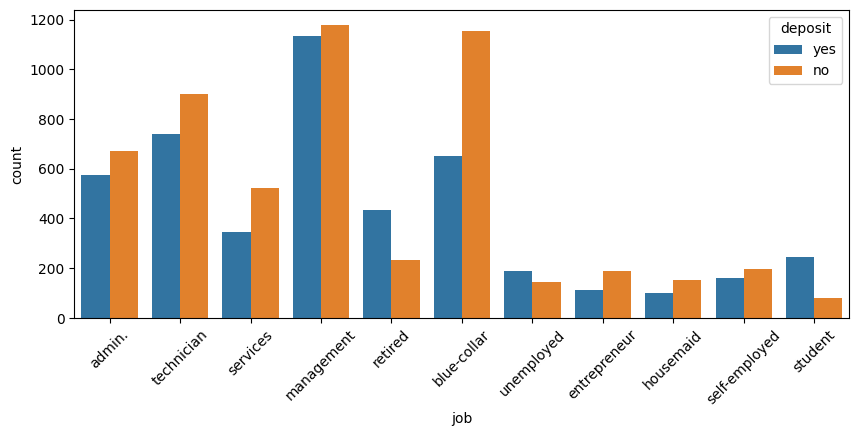

In [19]:
# визуализируем зависимость от вида профессиональной занятости
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x='job', hue='deposit', data=df)
ax.xaxis.set_tick_params(rotation=45);

2.8. Выше мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

In [20]:
# строим сводную таблицу
with_deposit = df[df['deposit'] == 'yes']
pd.crosstab(with_deposit['marital'], with_deposit['education'])

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


## Часть 3: Преобразование данных

3.1. Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

In [21]:
# создаем экземпляр класса LabelEncoder()
le = LabelEncoder()
# кодируем признак
df['education'] = le.fit_transform(df['education'])
df['education'].sum()

11995

3.2. Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [22]:
# кодируем признак
df['age_group'] = le.fit_transform(df['age_group'])

3.3. Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [23]:
# кодируем признак через lambda-функцию
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [24]:
# вычисляем стандартное отклонение целевого признака
round(df['deposit'].std(), 3)

0.499

3.4. Сделаем то же самое для других бинарных переменных, которых у нас три:
* 'default';
* 'housing';
* 'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [25]:
# кодируем признаки через lambda-функцию
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

3.5. Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:
* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'.

Создадим для них dummy-переменные и добавим их в набор данных.

In [26]:
# создаем дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

3.6. Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной. Для этого построим матрицу корреляций. Дополним её тепловой картой, отражающей результат. В качестве дополнения визуализации построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

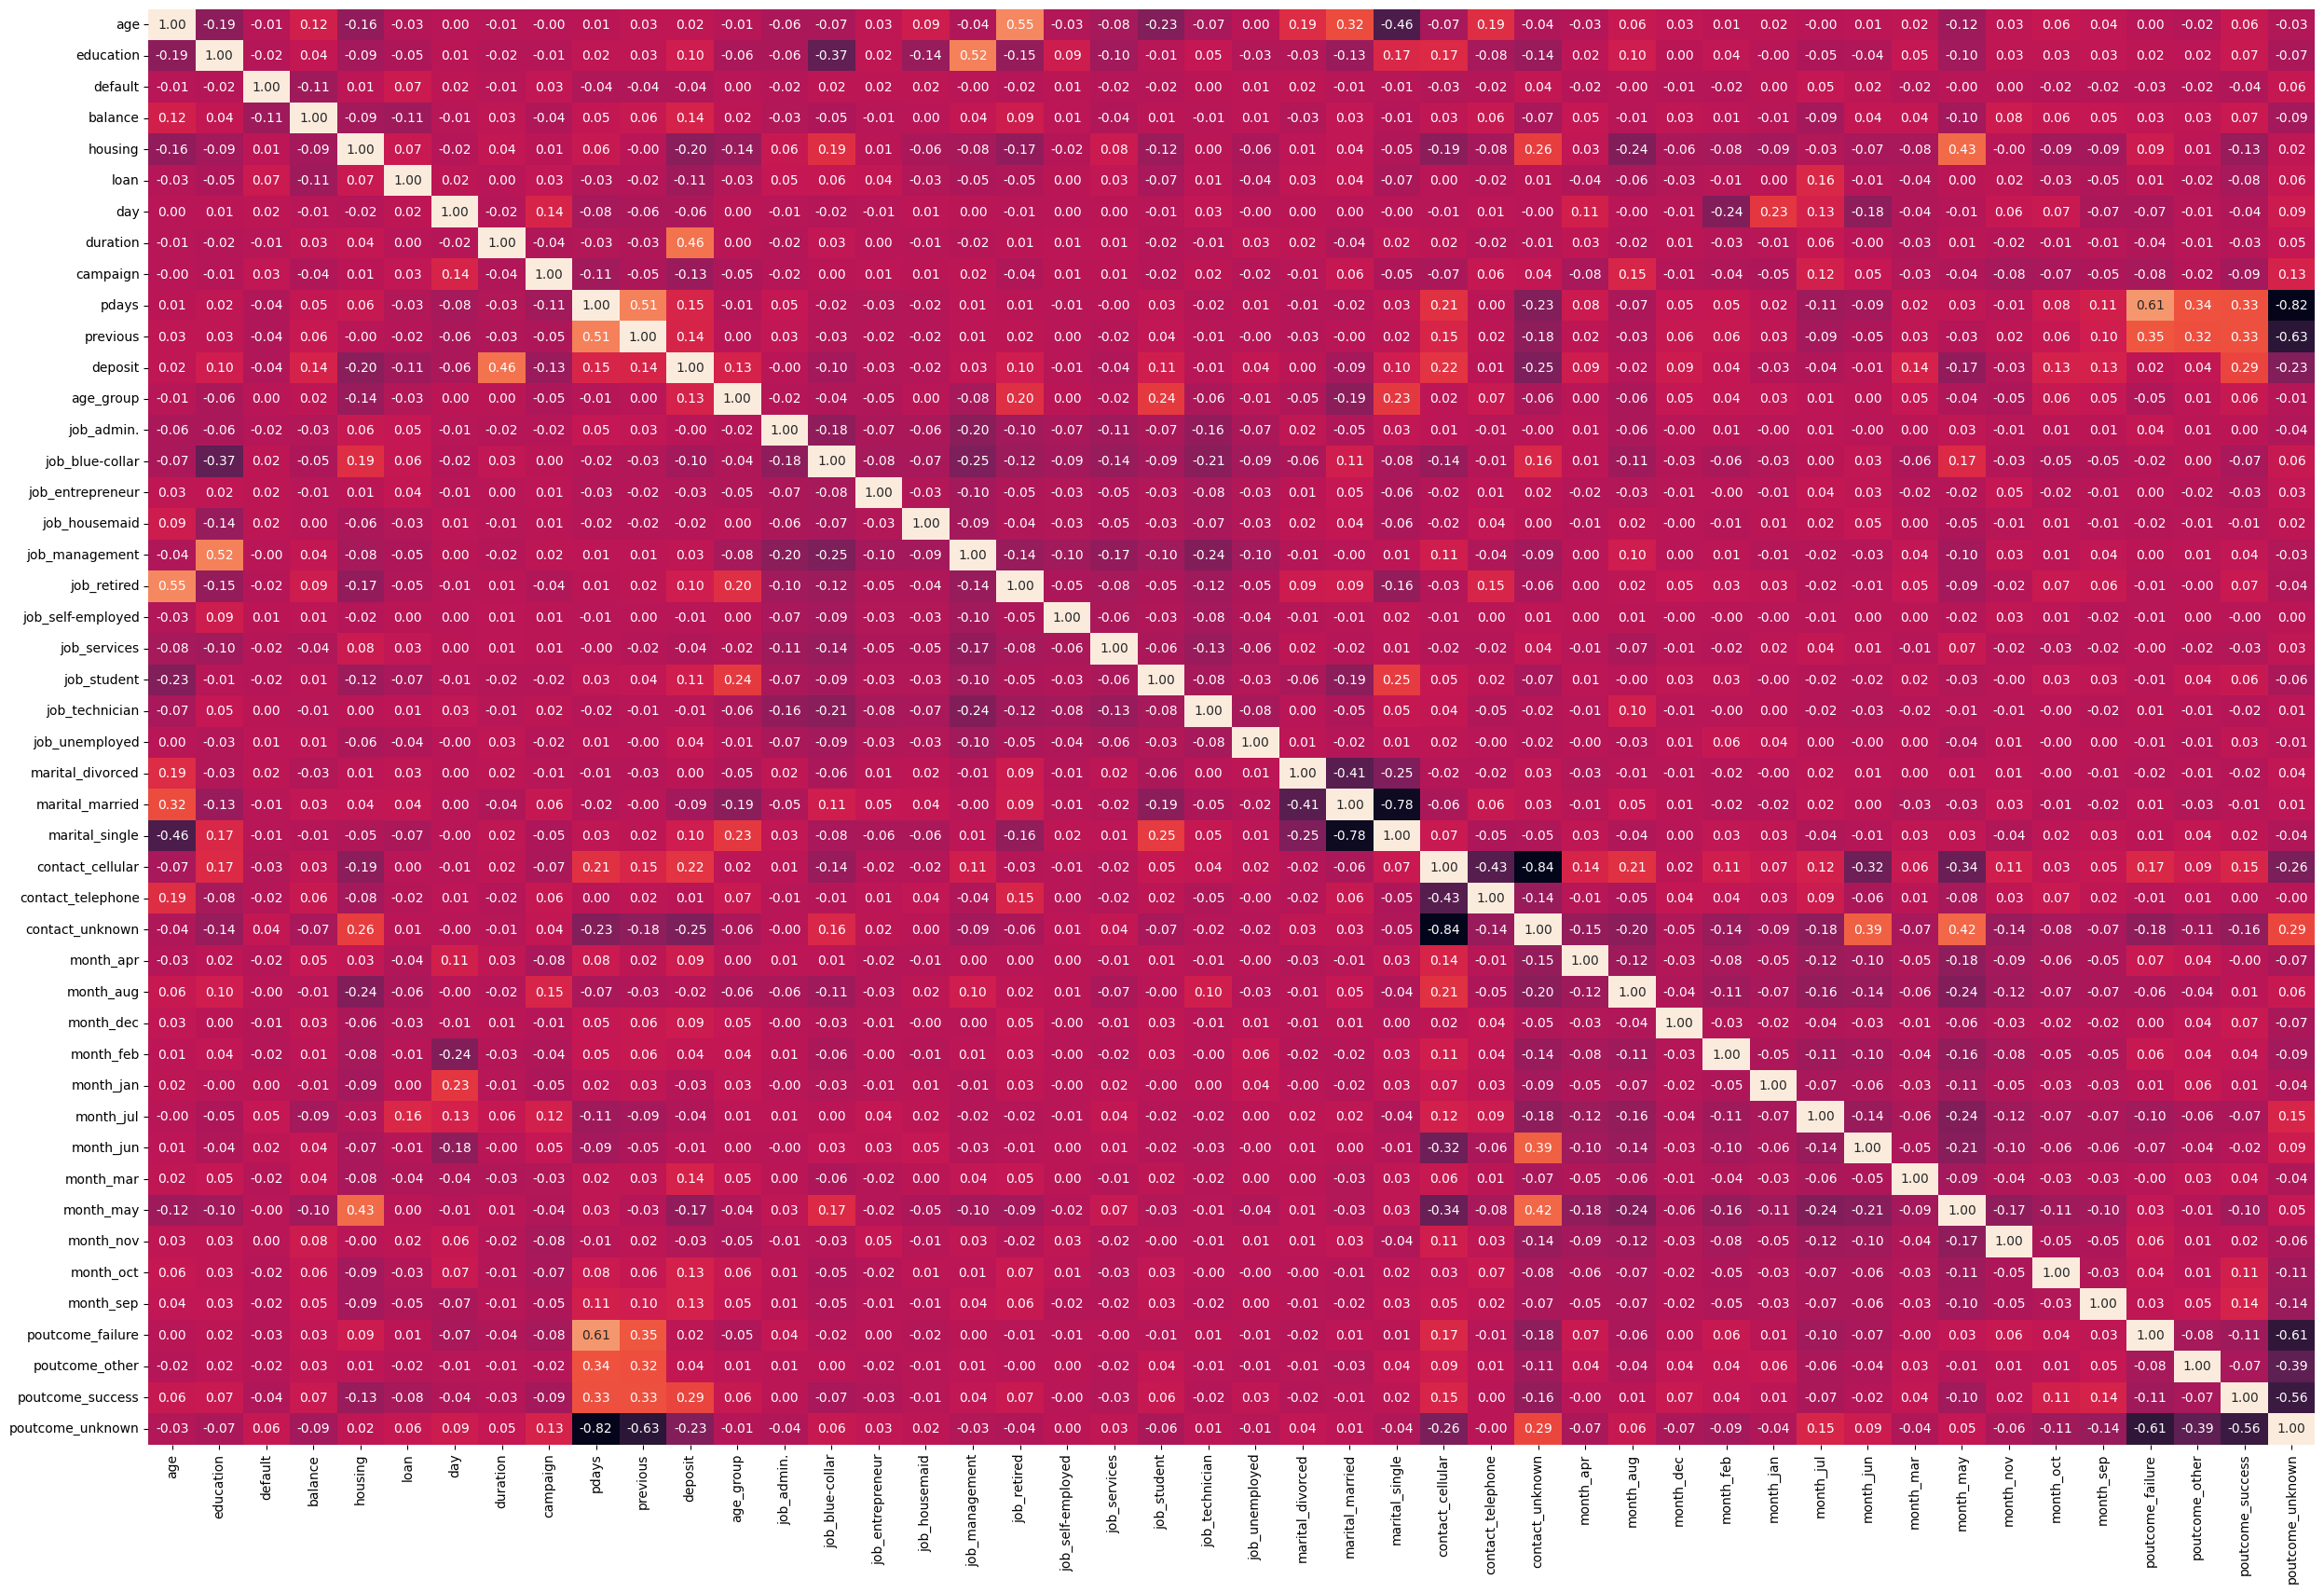

In [27]:
# строим тепловую карту корреляции признаков
fig = plt.figure(figsize=(30, 20))
sns.heatmap(
    df.corr(), 
    annot=True, 
    fmt='.2f',
    cbar=False
);

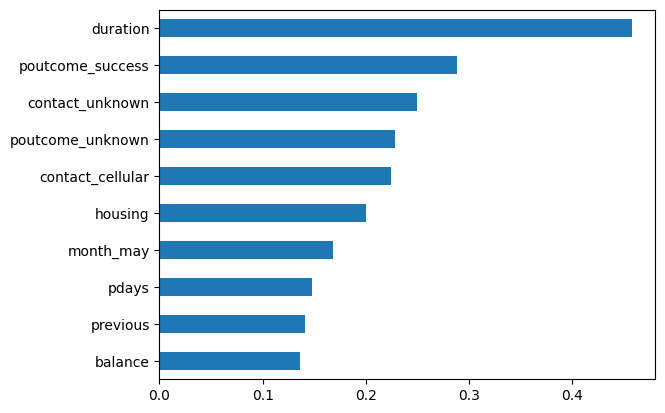

In [28]:
# строим столбчатую диаграмму ранжированных коэффициентов корреляции c признаком deposit
df.corr()['deposit'].apply(lambda x: abs(x)).sort_values()[-11:-1].plot.barh()
plt.show()

3.7. Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

In [29]:
# отделяем целевой признак
X = df.drop(['deposit'], axis=1)
y = df['deposit']
# разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

3.8. На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели. С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче.

In [30]:
# отбираем 15 лучших признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out().tolist()
best_features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [31]:
X = df[best_features]
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

3.8. Теперь данные необходимо нормализовать.

In [32]:
# производим нормализацию с помощью MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

4.1. Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [34]:
# создаем модель
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000
)
# обучаем модель
log_reg.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train Accuracy score: 0.82
Test Accuracy score: 0.81


4.2. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие: criterion = 'entropy'; random_state = 42. Остальные параметры оставим по умолчанию.

In [36]:
# создаем модель
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# обучаем модель
dt.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train Accuracy score: 1.00
Test Accuracy score: 0.75


Модель переобучена. Попробуем перебрать вручную различные максимальные глубины деревьев и найти глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т.е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [38]:
# создаем модель
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)
# обучаем модель
dt.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train Accuracy score: 0.82
Test Accuracy score: 0.81


4.3. Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

In [44]:
# задаем параметры
parameters = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}
# создаем модель
model_cv = GridSearchCV(
    tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    parameters,
    scoring=('f1')
)
# обучаем модель
model_cv.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = model_cv.predict(X_train_scaled)
y_test_pred = model_cv.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Train F1-score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best parameters: {}'.format(model_cv.best_params_))

Train Accuracy score: 0.84
Test Accuracy score: 0.81
Train F1-score: 0.83
Test F1-score: 0.80
Best parameters: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

5.1. Обучим случайный лес со следующими параметрами.

In [46]:
# создаем модель
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
# обучаем модель
rf.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Train Recall score: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Test Recall score: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train Accuracy score: 0.86
Test Accuracy score: 0.83
Train Recall score: 0.86
Test Recall score: 0.83


5.2. Мы не будем останавливаться на одной модели. Поэтому теперь предлагаем сравнить полученные результаты с моделью градиентного бустинга.

In [48]:
# создаем модель
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
# обучаем модель
gb.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Train F1-score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train Accuracy score: 0.89
Test Accuracy score: 0.83
Train F1-score: 0.88
Test F1-score: 0.82


5.3. Мы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа. Будем использовать стекинг, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

In [50]:
# создаем список из всех использованных моделей
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]
# создаем ансамбль
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
# обучаем модель
stack.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Train Precision score: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
print('Test Precision score: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Train Accuracy score: 0.87
Test Accuracy score: 0.82
Train Precision score: 0.86
Test Precision score: 0.81


5.4. Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

In [51]:
# отбираем 3 лучших признака
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out().tolist()
best_features

['duration', 'contact_unknown', 'poutcome_success']

5.5. Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако мы знаем, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров.

In [52]:
# создаем функцию
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-08-15 14:20:47,811] A new study created in memory with name: RandomForestClassifier
[I 2023-08-15 14:20:49,524] Trial 0 finished with value: 0.8608505315822388 and parameters: {'n_estimators': 130, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8608505315822388.
[I 2023-08-15 14:20:51,141] Trial 1 finished with value: 0.8892375274552872 and parameters: {'n_estimators': 123, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8892375274552872.
[I 2023-08-15 14:20:52,757] Trial 2 finished with value: 0.846190102120974 and parameters: {'n_estimators': 131, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8892375274552872.
[I 2023-08-15 14:20:54,249] Trial 3 finished with value: 0.8515099358472852 and parameters: {'n_estimators': 101, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8892375274552872.
[I 2023-08-15 14:20:55,935] Trial 4 finished with value: 0.843528856738481 and parameters: {'n_es

In [54]:
# создаем модель
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
# обучаем модель
model.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Train Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy score: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Train F1-score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best parameters: {}'.format(study.best_params))

Train Accuracy score: 0.93
Test Accuracy score: 0.83
Train F1-score: 0.92
Test F1-score: 0.82
Best parameters: {'n_estimators': 138, 'max_depth': 24, 'min_samples_leaf': 2}


Как показывают значения полученных метрик, ансамблевые модели случйного леса и градиентного бустинга справляются с нашей задачей немного лучше, чем методы логистической регрессии и дерева решений.